# QOSF Coding Task 4

#### Loading Libraries

In [162]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import networkx as nx
import statistics
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Parameter
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from qiskit.circuit.library.standard_gates import RXGate

from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import DigitalAnalogDevice
from pulser.waveforms import InterpolatedWaveform

## QAOA

Given a graph with $V$ vertices and $E$ edges, its maximum independent set is one containing no adjacent vertices. Thus, one can construct the objective function as follows, given that it is not a weighted problem:
\begin{equation}
f(x) = \sum_{i=1}^n x_i - \sum_{i, j = 1}^n x_ix_j
\end{equation}

While this problem is a maximization problem, converting it to minimization is trivial: (flipping the signs of the linear and quadratic term in this case). 
This function can be expanded into gate-form by replacing every variable $x_i$ with $2^{-1}(I-Z_i)$
By doing so:

\begin{equation}
H_c = \sum_{i, j = 1}^n \frac{1}{4}(Z_iZ_j - Z_i - Z_j) -\sum_{i=1}^n \frac{1}{2} Z_i
\end{equation}

The initial state is an equal superposition of all states, while the mixer used is equivelant to that of the original QAOA formulation: $H_m = \sum_{i=1}^n  X_i$

The two alternating unitaries can be written as:
\begin{equation}
U_c(\gamma) = e^{-i\gamma H_c}
\end{equation}
\begin{equation}
U_m(\beta) = e^{-i\beta H_m}
\end{equation}

This is implemented in the cells below. While only one layer is used, the code is written such that more layers can easily be added. Initial parameter values are chosen to be uniform: [0.0, 0.0]

In [612]:
def create_circ(G, theta):
    n = len(G.nodes())
    circ = QuantumCircuit(n)

    # initial state
    for i in range(n):
        circ.h(i)
    
    l = len(theta)//2  # get number of layers
    beta = theta[:l]
    gamma = theta[l:]

    for it in range(l):
        # cost
        for i in range(n):
            for j in range(0, adj[i].size):
                circ.rz(-0.5*gamma[it], i)
                # coupled
        for pair in G.edges():
            circ.rz(-0.25*gamma[it], pair[0])
            circ.rz(-0.25*gamma[it], pair[1])
            circ.rzz(0.25*gamma[it], pair[0], pair[1])
        
        # mixer
        for i in range(n):
            circ.rx(beta[it], i)
    
    circ.measure_all()
    return circ 

In [164]:
# get average expectation
def get_expectation(counts):
    avg = 0
    size = 0
    for bitstring, count in counts.items():
        avg += get_cost(bitstring)*count
        size += count
    return avg/size

# get cost given bitstring (for MIS: number of vertices in independent set)
def get_cost(bitstring):
    cost = 0
    for v in bitstring:
        if v == '1':
            cost -= 1
    return cost

In [243]:
# function to execute circ
def run_circ(G):
    def run(theta):
        backend = Aer.get_backend('qasm_simulator')
        qc = create_circ(G, theta)
        counts = backend.run(qc, shots=1024).result().get_counts()
        return get_expectation(counts)
    return run

# optimizing parameters
def get_result(G):
    expectation = run_circ(G)
    result = minimize(expectation, [0.0, 0.0], method='COBYLA')
    return result

# get counts given optimized beta and gamma
def get_probable_counts(G, result):
    res = create_circ(G, result.x)
    backend = Aer.get_backend('qasm_simulator')
    counts = backend.run(res).result().get_counts()
    return counts

## QAA

The following cells provide functions used to run QAA to solve MIS
Using QAA depends upon the right formulation of the problem into a QUBO to be translated to a Hamiltonian (Which is ultimately done by Pulsar). 
The formulation of MIS as a QUBO is rather simple:
Given the adjacency matrix of graph $G$, let the diagonal elements be equal to -1, and the off diagonals 2. (That is, reduce the overall cost when adding vertices but increase when adjacent vertices are added)

In [504]:
# determine and get register
def evaluate_mapping(new_coords, *args):
    Q, shape = args
    new_coords = np.reshape(new_coords, shape)
    new_Q = squareform(
        DigitalAnalogDevice.interaction_coeff / pdist(new_coords) ** 6
    )
    return np.linalg.norm(new_Q - Q)

def get_register(Q):
    shape = (len(Q), 2)
    costs = []
    np.random.seed(0)
    x0 = np.random.random(shape).flatten()
    res = minimize(
        evaluate_mapping,
        x0,
        args=(Q, shape),
        method="Nelder-Mead",
        tol=1e-6,
        options={"maxiter": 200000, "maxfev": None},)
    coords = np.reshape(res.x, (len(Q), 2))
    qubits = dict(enumerate(coords))
    reg = Register(qubits)
    return reg

# Qubo formulation of graph
def get_qubo(G):
    Q = np.array(nx.adjacency_matrix(G).todense())
    for i in range(len(Q)):
        # quadratic weights
        for j in range(len(Q)):
            Q[i][j] *= 2

        # linear weights
        Q[i][i] = -1
    return Q

In [227]:
# return dictionary of counts
def get_QAA_counts(Q, reg):
    Omega = np.median(Q[Q > 0].flatten())
    delta_0 = -4 
    delta_f = -delta_0
    T = 4000 
    
    adiabatic_pulse = Pulse(
        InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
        InterpolatedWaveform(T, [delta_0, 0, delta_f]),
        0,
    )
    seq = Sequence(reg, DigitalAnalogDevice)
    seq.declare_channel("ising", "rydberg_global")
    seq.add(adiabatic_pulse, "ising")
    simul = QutipEmulator.from_sequence(seq)
    results = simul.run().sample_final_state()
    return results

In [170]:
# color map to compare results
def get_color_map(bitstr):
    color_map = []
    for i in bitstr:
        if i == '0':
            color_map.append('blue')
        else:
            color_map.append('red')
    return color_map

### Observations

The QAA solution is often more accurate and more consistent than QAOA. For many of the graphs, there is little variability when run multiple times, and have more clear peaks. QAOA fails to find the most optimimum solution in most cases which may be due to a couple factors including the representation of the Hamiltonian. It is much slower, which is exacerbated as the number of nodes in the graph increases, given the classical optimization that must be performed. 

The results to QAOA can likely be improved by rethinking the Hamiltonian, increasing the number of iterations, or number of layers in gamma and beta. Furthermore, it would be interesting to determine how large of an effect the initial parameters have on the success of optimization

The graphs and resulting count distributions and solution (given most frequent bitstring) for QAOA and QAA can be found below

## Testing

### 3 Node Graph

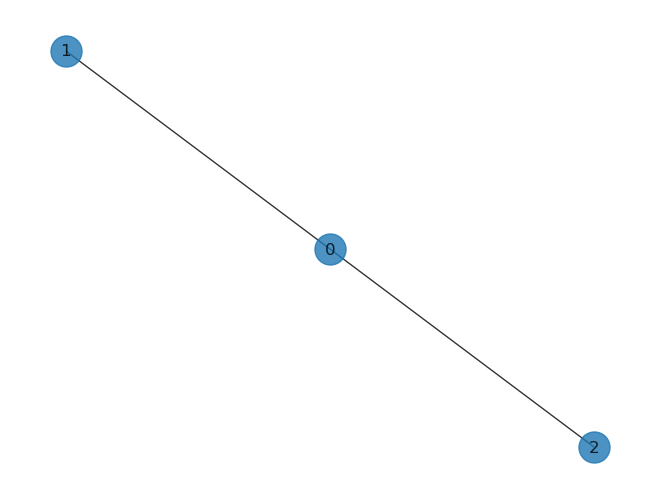

In [613]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2])
G.add_edges_from([(0,2), (0,1)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)
print()

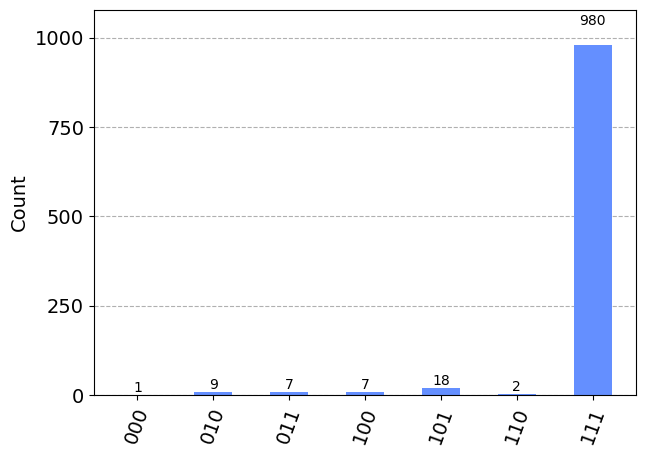

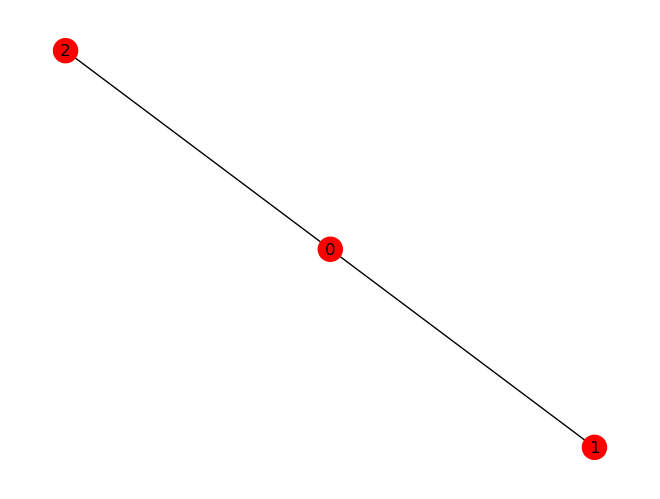

In [614]:
#QAOA Solution:
QAOA_counts = get_probable_counts(G, get_result(G))
plot_histogram(QAOA_counts)
nx.draw(G, node_color=get_color_map(QAOA_counts.most_frequent()[::-1]), with_labels=True)

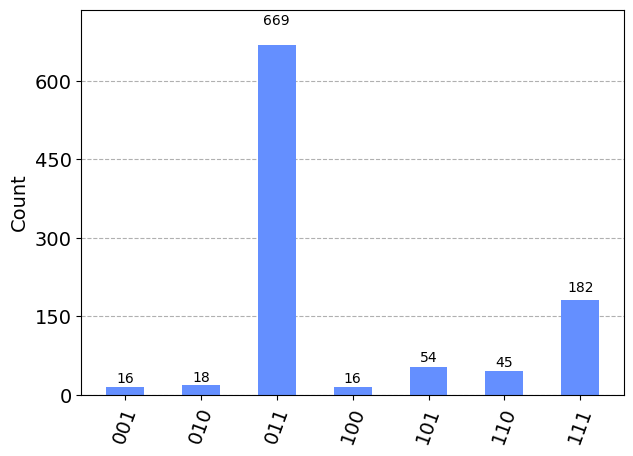

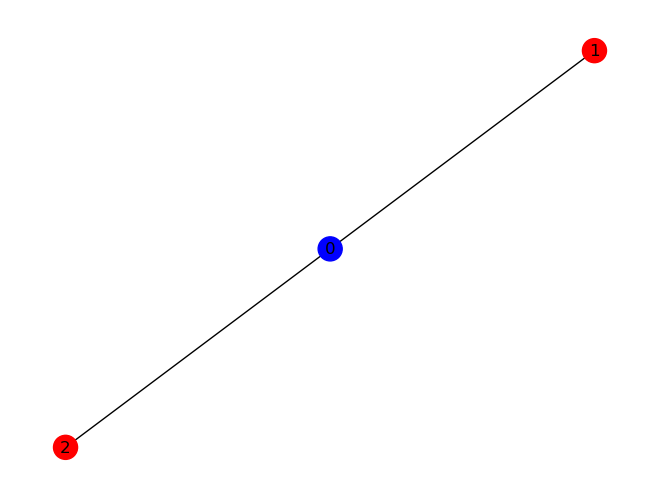

In [615]:
# QAA Solution
Q = get_qubo(G)
QAA_counts = get_QAA_counts(Q, get_register(Q))
plot_histogram(QAA_counts)
nx.draw(G, node_color=get_color_map(max(QAA_counts, key=QAA_counts.get)), with_labels=True)

### 5 Node Graph

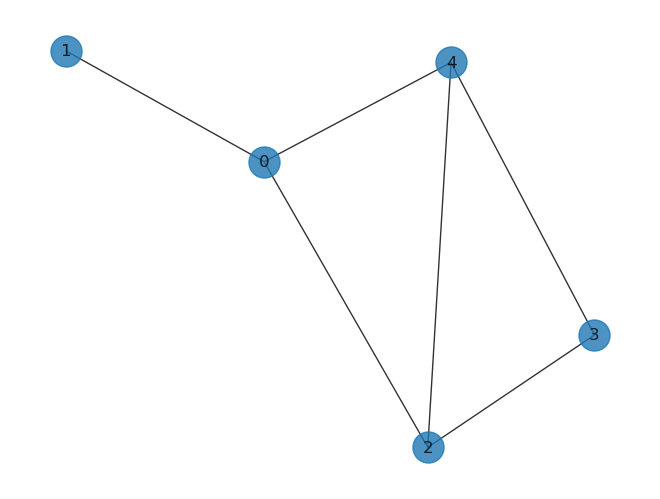

In [616]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([(0,2), (2, 4), (2, 3), (0, 4), (0, 1), (3, 4)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

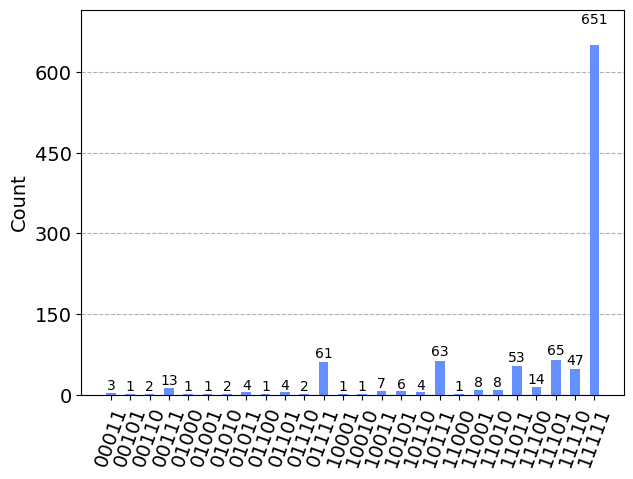

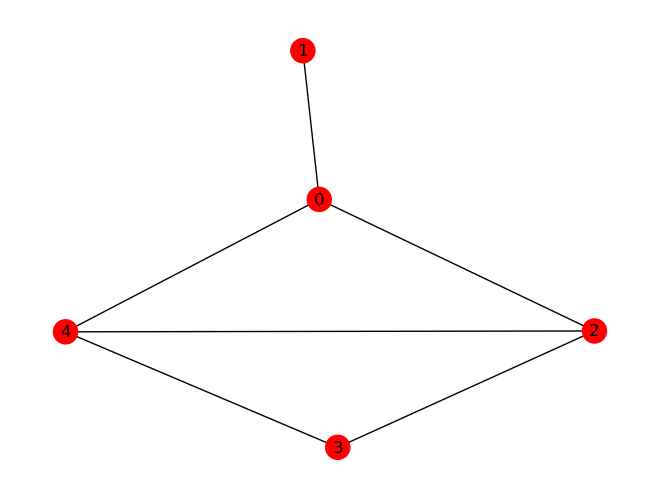

In [617]:
#QAOA Solution:
QAOA_counts = get_probable_counts(G, get_result(G))
plot_histogram(QAOA_counts)
nx.draw(G, node_color=get_color_map(QAOA_counts.most_frequent()[::-1]), with_labels=True)

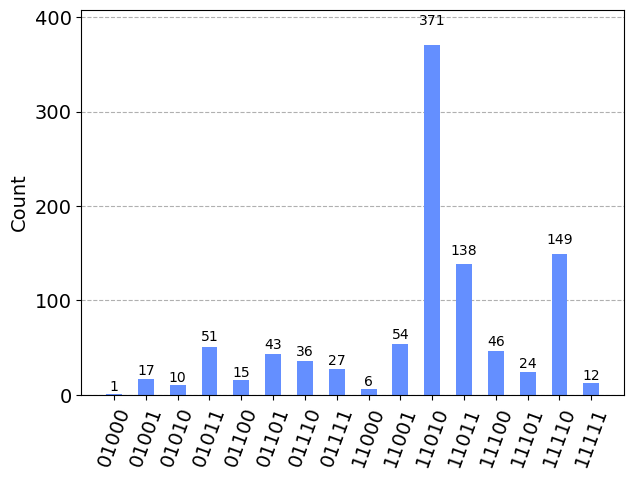

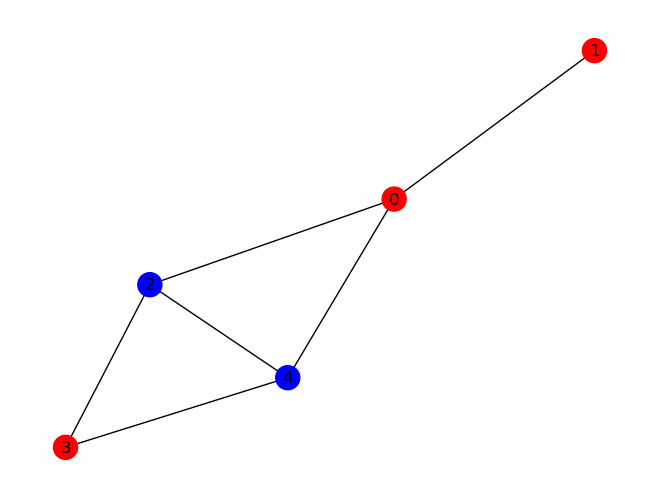

In [618]:
# QAA Solution
Q = get_qubo(G)
QAA_counts = get_QAA_counts(Q, get_register(Q))
plot_histogram(QAA_counts)
nx.draw(G, node_color=get_color_map(max(QAA_counts, key=QAA_counts.get)), with_labels=True)

### 6 Node Graph

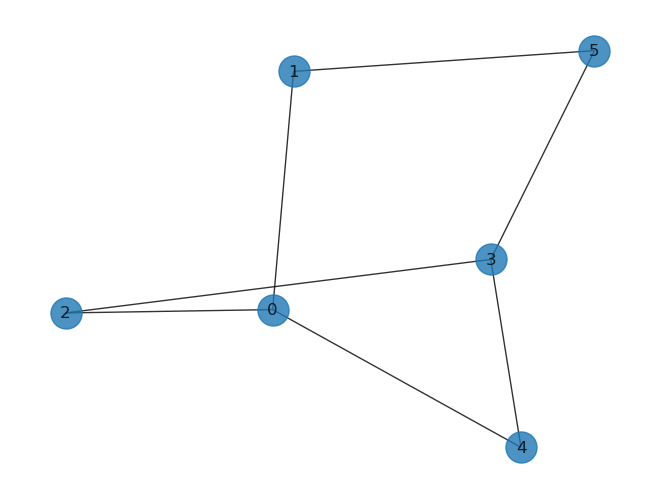

In [619]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4, 5])
G.add_edges_from([(0,2), (2, 3), (0, 4), (0, 1), (3, 4), (1, 5), (5,3)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

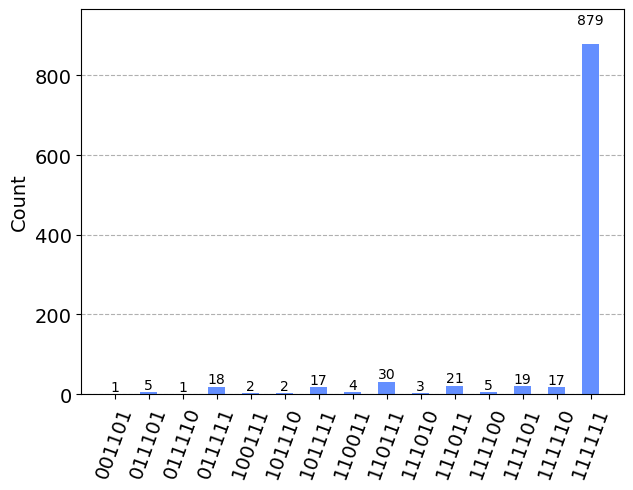

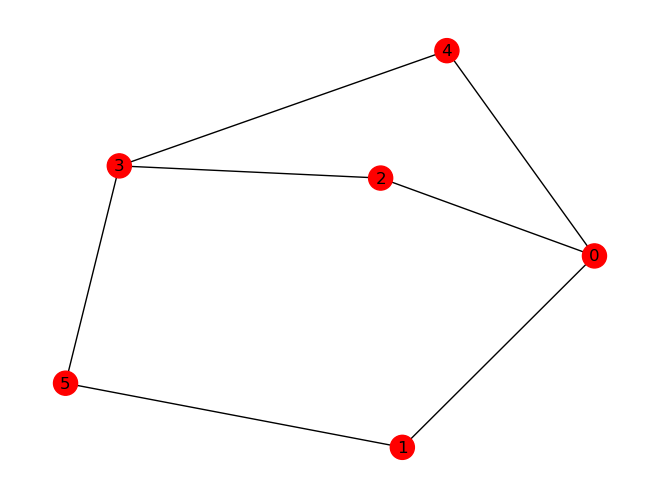

In [620]:
#QAOA Solution:
QAOA_counts = get_probable_counts(G, get_result(G))
plot_histogram(QAOA_counts)
nx.draw(G, node_color=get_color_map(QAOA_counts.most_frequent()[::-1]), with_labels=True)

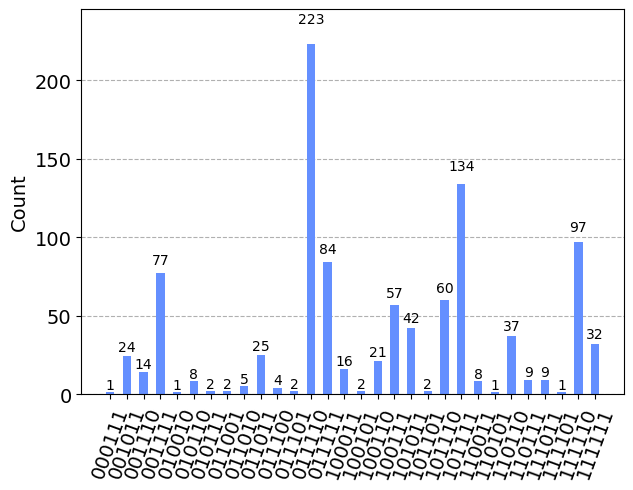

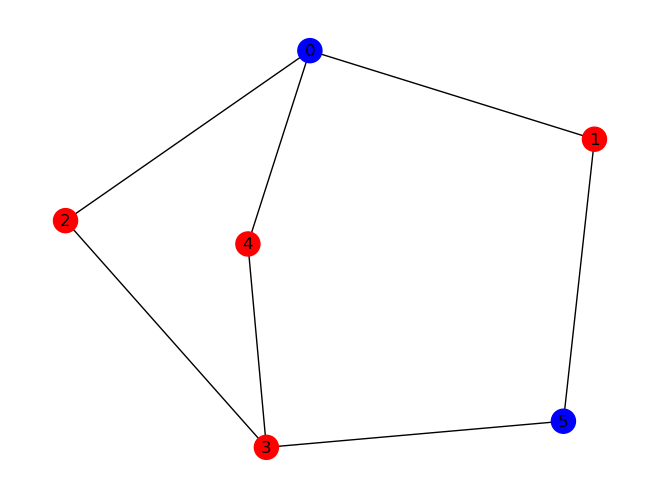

In [621]:
# QAA Solution
Q = get_qubo(G)
QAA_counts = get_QAA_counts(Q, get_register(Q))
plot_histogram(QAA_counts)
nx.draw(G, node_color=get_color_map(max(QAA_counts, key=QAA_counts.get)), with_labels=True)

### 7 Node Graph

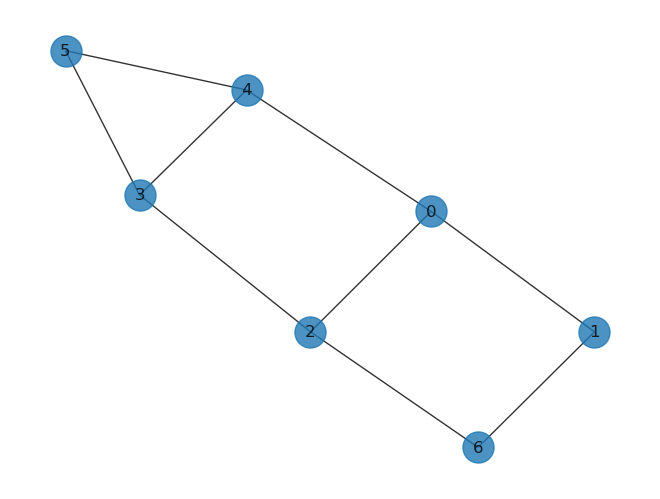

In [622]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4, 5, 6])
G.add_edges_from([(0,2), (2, 3), (0, 4), (0, 1), (3, 4), (5,3), (5, 4), (1, 6), (6, 2)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

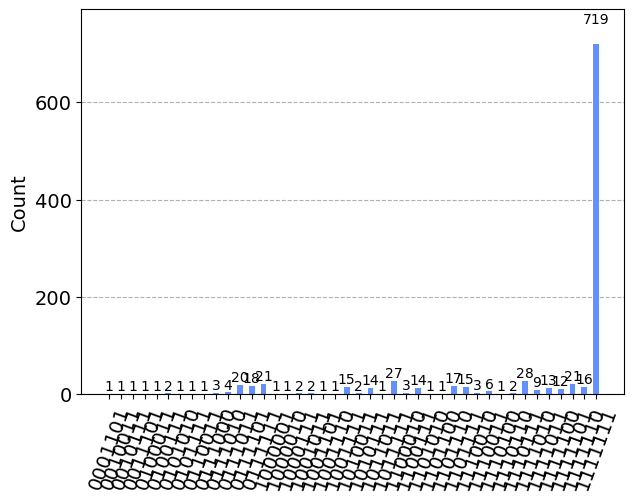

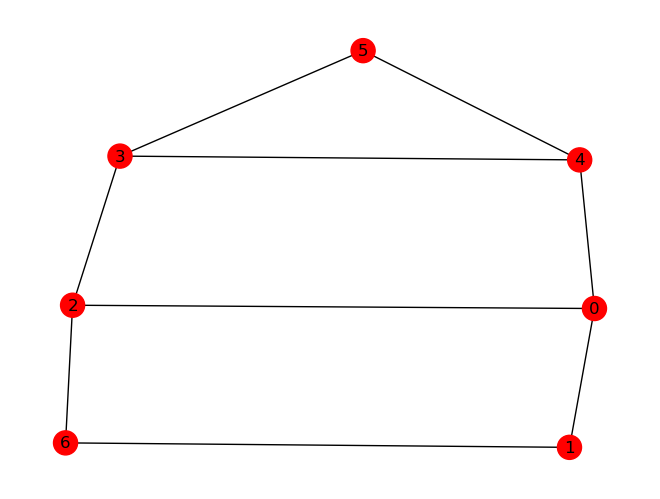

In [623]:
#QAOA Solution:
QAOA_counts = get_probable_counts(G, get_result(G))
plot_histogram(QAOA_counts)
nx.draw(G, node_color=get_color_map(QAOA_counts.most_frequent()[::-1]), with_labels=True)

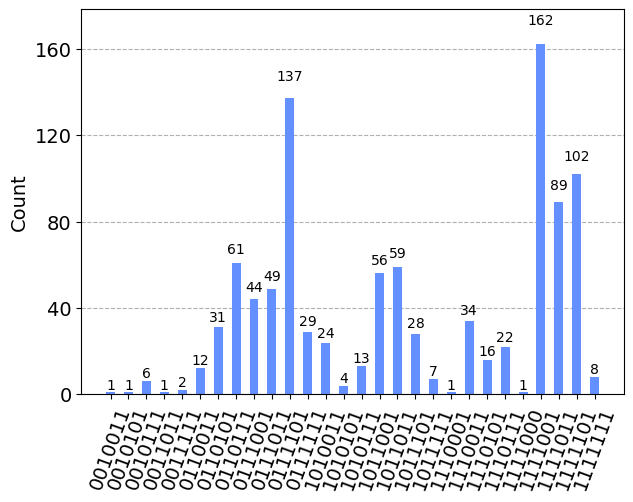

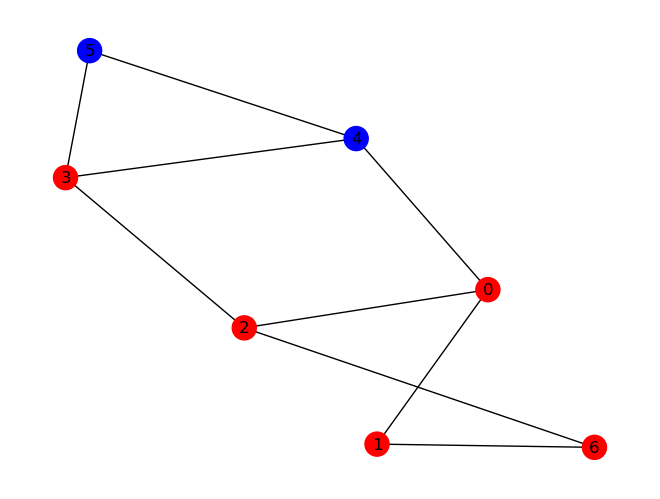

In [624]:
#QAA Solution
Q = get_qubo(G)
QAA_counts = get_QAA_counts(Q, get_register(Q))
plot_histogram(QAA_counts)
nx.draw(G, node_color=get_color_map(max(QAA_counts, key=QAA_counts.get)), with_labels=True)